# Ensemble Evaluation: Timepoint 1 - Spring 2020

Location: New York State

Timepoint 1: April 3, 2020. Setting: New York State at the beginning of the pandemic when masking was the main preventative measure. No vaccines available. 

Using case and death data for calibration (hospitalization data not available for this timepoint). No vaccination, no variants, and reinfection is not considered.

## Set up for ensemble modeling

### Load dependencies

In [1]:
from pyciemss.utils.ensemble_eval_utils import * 

### Collect relevant models
<!-- We have chosen x number of models to capture the relevant COVID-19 dynamics for this setting. 
 - `model1` contains compartments SEIRHD, and is stratified by age into four groups.
 - `model2` is the same as `model1`, but allows for reinfection
 - `model3` is the same as `model1`, but with a variation in transmission rate to account for masking efficacy and compliance. -->

In [2]:
from mira.sources.askenet import model_from_url
model1 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_ee.json')
model2 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v2.json')
model3 = model_from_url('https://raw.githubusercontent.com/ciemss/pyciemss/sa-ensemble-eval/notebook/ensemble_eval_sa/operative_models/SEIRHD_npi1_age_stratified_v3.json')

### Gather data, and set training and forecast intervals
For this timepoint, only case and death data is available for calibration. 

We take the total population of New York State to be 19,340,000. Population age-structure estimates for New York State were taken (and scaled appropriately) from [here](https://www.health.ny.gov/statistics/vital_statistics/2016/table01.htm).

First recorded case in New York State: March 1, 2020.

Also relevant is that a statewide stay-at-home order for non-essential workers was implemented on March 22, 2020, and masking policy was implemented on April 15, 2020. A nice list of COVID-19 policy interventions for New York City and State has been compiled [here](https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986![image.png](attachment:d380d245-11ca-41f1-9863-e2a2dcf5ebce.png)![image.png](attachment:b30f6e31-bc7f-43a8-b7c8-b1df78db3b86.png)![image.png](attachment:b5109588-59ed-447c-9271-50eb56fe9081.png)![image.png](attachment:2c42138a-696d-4cef-9b79-4843d38ff029.png)).

### Gather source data and set `DATA_PATH`, `RESULTS_PATH`

In [4]:
url = 'https://raw.githubusercontent.com/DARPA-ASKEM/experiments/main/thin-thread-examples/milestone_12month/evaluation/ensemble_eval_SA/datasets/aabb3684-a7ea-4f60-98f1-a8e673ad6df5/dataset.csv'
nys_data = pd.read_csv(url)
nys_data["E"] = np.nan # Add empty "E" column so that "exposed" may be used to post-process results

DATA_PATH = "../../notebook/ensemble_eval_sa/datasets/"
RESULTS_PATH = "../../notebook/ensemble_eval_sa/ensemble_results/"

### Create and save datasets and simulation timepoints for each forecast

In [5]:
### Forecast 1: 04/03/2020 - 05/01/2020, data: 03/01/2020 - 04/02/2020

# Forecast 1: 04/03/2020 (day 32, row 73) - 05/01/2020 (day 60, row 101), train data: 03/01/2020 (day 0, row 40) - 04/02/2020 (day 31, row 72)
[all_data1, train_data1, timepoints1] = data_selector_function(nys_data, 39, 72, 101)
train_data1[["I", "E", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast1.csv")

### Forecast 2: 04/10/2020 - 05/08/2020, data: 03/01/2020 - 04/09/2020

# Forecast 2: 04/10/2020 (day 39, row 80) - 05/08/2020 (day 67, row 108), train data: 03/01/2020 (day 0, row 40) - 04/09/2020 (day 38, row 79)
[all_data2, train_data2, timepoints2] = data_selector_function(nys_data, 39, 79, 108)
train_data2[["I", "E", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast2.csv")

### Forecast 3: 04/17/2020 - 05/15/2020, data: 03/01/2020 - 04/16/2020

# Forecast 3: 04/17/2020 (day 46, row 87) - 05/15/2020 (day 74, row 115), train data: 03/01/2020 (day 0, row 40) - 04/16/2020 (day 45, row 86)
[all_data3, train_data3, timepoints3] = data_selector_function(nys_data, 39, 86, 115)
train_data3[["I", "E", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast3.csv")

### Forecast 4: 04/24/2020 - 05/22/2020, data: 03/01/2020 - 04/23/2020

# Forecast 3: 04/24/2020 (day 53, row 94) - 05/22/2020 (day 81, row 122), train data: 03/01/2020 (day 0, row 40) - 04/23/2020 (day 52, row 93)
[all_data4, train_data4, timepoints4] = data_selector_function(nys_data, 39, 93, 122)
train_data4[["I", "E", "H", "D"]].to_csv(DATA_PATH + "NYS_T1_forecast4.csv")

### Plot the data

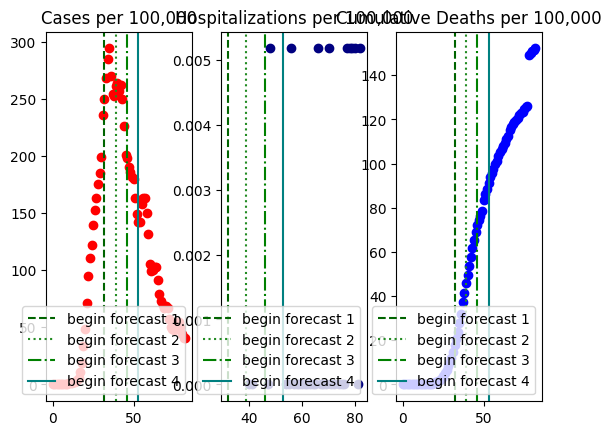

In [6]:
N = 19_340_000
plot_case_hosp_death_data(N, all_data4)

# (1) Forecast 1: 04/03/2020 - 05/01/2020

## (A) Calibrate and sample an ensemble of one model

In [7]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Apr032020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Apr032020.csv"
N_ITERATIONS = 26

### MODEL 1 - SEIRHD with NPI of Type 1

In [8]:
num_samples = 100
models = [model1]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "I", "E": "E", "H": "H", "D": "D"}]

# Run the calibration and sampling
result1A1 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A1["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

iteration 0: loss = 708.4114954471588
iteration 25: loss = 690.3458123207092



### Post-process and save results, formatted quantiles

In [9]:
# Define functions to get incident cases, hospitalizations, and deaths
def get_incident_cases(delta, exposed): # delta * Exposed
    return delta * exposed

def get_incident_hosp(eta, gamma, infectious): # eta * gamma * Infectious
    return eta * gamma * infectious

def get_incident_deaths(mu, los, hospitalized): # (mu/los) * Hospitalized
    return (mu/los) * hospitalized

results_df = result1A1["data"]
results_df["Incident_Cases_sol"] = results_df.apply(lambda row: get_incident_cases(row['model_0/delta_param'], row['E_sol']), axis=1)
results_df["Incident_Hosp_sol"] = results_df.apply(lambda row: get_incident_hosp(row['model_0/eta_param'], row['model_0/gamma_param'], row['I_sol']), axis=1)
results_df["Incident_Deaths_sol"] = results_df.apply(lambda row: get_incident_deaths(row['model_0/mu_param'], row['model_0/los_param'], row['H_sol']), axis=1)

# Save processed results
results_df.to_csv(RESULTS_FILENAME, index=False)
process_and_save_quantiles(results_df, QUANTILES_FILENAME, timepoints1, train_data1, "2020-04-02", "New York State")

### MODEL 2 - Age-Structured SEIRHD with NPI of Type I, Model Version 2

In [ ]:
num_samples = 100
models = [model2]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result1A2 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result1A2["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result1A2["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A2["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process results

In [ ]:
result1A2["data"]

### MODEL 3 - Age-Structured SEIRHD with NPI of Type I, Model Version 3

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result1A3 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result1A3["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result1A3["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1A3["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
result1A3["data"]

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of3_results_Apr042020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of3_quantiles_Apr042020.csv"
N_ITERATIONS = 400

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result1B1 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result1B1["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result1B1["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# q_ensemble_data = cdc_reformatcsv(filename="../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", 
#                                   solution_string_mapping={"I": "cases", "D": "deaths"}, 
#                                   forecast_start_date="2020-04-02",
#                                   location="New York State",
#                                   drop_column_names=["timepoint_id", "number_days", "inc_cum", "output", "Forecast_Backcast"])
# q_ensemble_data.to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_forecast_quantiles_Apr032020.csv")

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B1["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [ ]:
num_samples = 100
models = [model1, model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result1B2 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result1B2["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_two_results.csv", index=False)
# result1B2["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_two_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B2["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [0.1, 0.4, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result1B3 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result1B3["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result1B3["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B3["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast1.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result1B4 = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints1,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result1B4["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result1B4["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result1B4["data"]), keep=".*_sol",
                            points=all_data1.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

# (2) Forecast 2: 04/10/2020 - 05/08/2020

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T1_forecast2.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result2A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints2,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result2A["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result2A["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result2A["data"]), keep=".*_sol",
                            points=all_data2.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Apr102020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Apr102020.csv"

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast2.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result2B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints2,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result2B["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result2B["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result2B["data"]), keep=".*_sol",
                            points=all_data2.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of3_results_Apr102020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of3_quantiles_Apr102020.csv"

# (3) Forecast 3: 04/17/2020 - 05/15/2020

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T1_forecast3.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result3A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints3,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result3A["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result3A["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result3A["data"]), keep=".*_sol",
                            points=all_data3.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Apr172020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Apr172020.csv"

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast3.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result3B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints3,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result3B["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result3B["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result3B["data"]), keep=".*_sol",
                            points=all_data3.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of3_results_Apr172020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of3_quantiles_Apr172020.csv"

# (4) Forecast 4: 04/24/2020 - 05/22/2020

## (A) Calibrate and sample an ensemble of one model

In [ ]:
num_samples = 100
models = [model3]
data_location = DATA_PATH + "NYS_T1_forecast4.csv"
weights = [1]
solution_mappings = [{"I": "infected", "H": "hospitalized", "D": "dead"}]

# Run the calibration and sampling
result4A = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints4,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# # Save results
# result4A["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_results.csv", index=False)
# result4A["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_one_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4A["data"]), keep=".*_sol",
                            points=all_data4.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of1_results_Apr242020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of1_quantiles_Apr242020.csv"

## (B) Calibrate and sample an ensemble of multiple models

In [ ]:
num_samples = 100
models = [model1, model2, model3]
data_location = DATA_PATH + "NYS_T1_forecast4.csv"
weights = [0.2, 0.3, 0.5] # [1/len(models) for i in models]
solution_mappings = [{"I": "I", "H": "H", "D": "D"},
                     {"I": "infected", "H": "hospitalized", "D": "dead"}, 
                     {"I": "infected", "H": "hospitalized", "D": "dead"}
                     ]

# Run the calibration and sampling
result4B = load_and_calibrate_and_sample_ensemble_model(
    models,
    data_location,
    weights,
    solution_mappings,
    num_samples,
    timepoints4,
    verbose=True,
    total_population=19340000,
    num_iterations=N_ITERATIONS,
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)

# Save results
# result4B["data"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_results.csv", index=False)
# result4B["quantiles"].to_csv("../../notebook/ensemble_eval_sa/ensemble_results/partI_ensemble_of_many_quantiles.csv", index=False)

# Plot results
schema = plots.trajectories(pd.DataFrame(result4B["data"]), keep=".*_sol",
                            points=all_data4.reset_index(drop=True).rename(columns={"I":"I_data", "H":"H_data", "D":"D_data"}),
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

### Post-process and save results

In [ ]:
RESULTS_FILENAME = RESULTS_PATH + "T1_ensemble_of3_results_Apr242020.csv"
QUANTILES_FILENAME = RESULTS_PATH + "T1_ensemble_of3_quantiles_Apr242020.csv"